In [1]:
import tensorflow as tf
print("tensorflow version is", tf.__version__)
print("keras version is", tf.keras.__version__)

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.initializers import RandomNormal
import os
import itertools
import matplotlib.pyplot as plt
import numpy as np

plt.ioff()  # not to show images inline
os.makedirs("out3", exist_ok=True)

tensorflow version is 2.1.0
keras version is 2.2.4-tf


In [2]:
(x_tr, y_tr), (x_te, y_te) = cifar10.load_data()
print(x_tr.shape, y_tr.shape, x_te.shape, y_te.shape)
print(np.min(x_tr), np.max(x_tr), np.min(x_te), np.max(x_tr))

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
0 255 0 255


* Sample training samples *


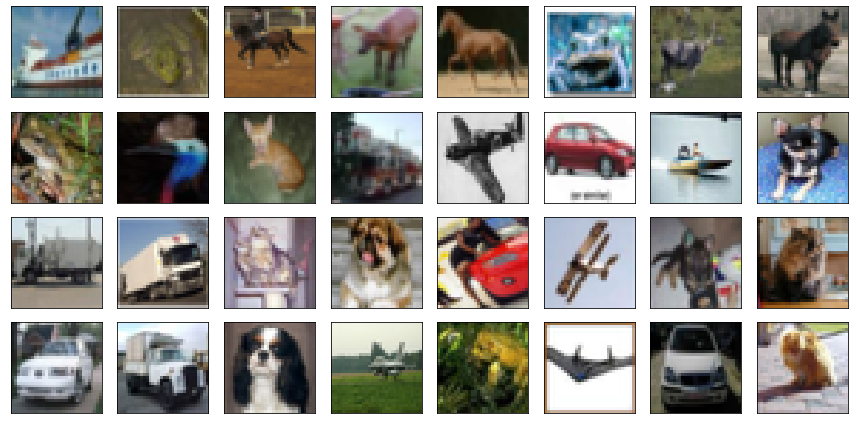

In [3]:
def plot_images(images, nrow=4, ncol=8, figsize=(12, 6)):
    fig, ax = plt.subplots(nrow, ncol, figsize=figsize)
    for i, j in itertools.product(range(nrow), range(ncol)):
        k = i*ncol + j
        if k < len(images):
            ax[i][j].imshow(images[k])
        ax[i][j].xaxis.set_visible(False)
        ax[i][j].yaxis.set_visible(False)
    fig.tight_layout()
    plt.close(fig)
    return fig

print("* Sample training samples *")
i = np.random.choice(len(x_tr), size=32, replace=False)
plot_images(x_tr[i])

* Sample test samples *


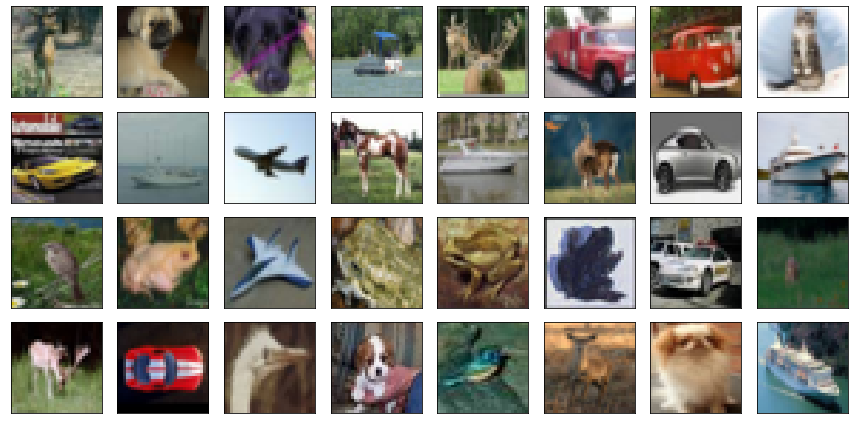

In [4]:
print("* Sample test samples *")
i = np.random.choice(len(x_te), size=32, replace=False)
plot_images(x_te[i])

(32, 32, 32, 3) -1.0 1.0


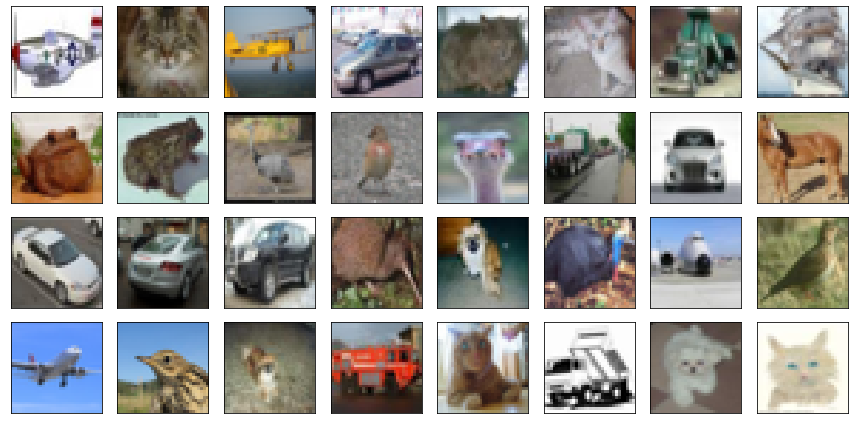

In [5]:
class Dataset:
    def __init__(self, data, normalizer=None):
        self.data = data.astype("float32")
        self.normalizer = normalizer
        self.index = 0  # current index
        self.iter_count = 0  # number of completed iteration
        self.randomize()

    def randomize(self):
        n = len(self.data)
        ix = np.random.permutation(n)
        self.data = self.data[ix]
    
    def get(self, size):
        out = self._get(size)
        if self.normalizer is None:
            return out
        else:
            return self.normalizer(out)

    def _get(self, size):
        n = len(self.data)
        i1 = self.index
        i2 = min(n, self.index + size)
        if i2 >= n:
            self.iter_count += 1
            self.randomize()
        out = self.data[i1:i2]
        self.index = (i2 % n)
        if len(out) == size:
            return out
        else:
            size_remain = size - len(out)
            out2 = self.get(size_remain)
            out = np.vstack((out, out2))
            return out

class Normalizer:
    def __init__(self, low=-1.0, high=1.0):
        self.low = low
        self.high = high
    
    def __call__(self, x, inv=False):
        return x * (self.high - self.low) / 255.0 + self.low

# test
data = Dataset(x_tr, normalizer=Normalizer())
test = data.get(32)
print(test.shape, np.min(test), np.max(test))
test = ((test + 1) * 255 / 2).astype(int)  # rescale to [0, 255]
plot_images(test)

In [6]:
def make_discriminator(filters=(64,128,128,256), kernel=(3,3), input_shape=(32,32,3)):
    initializer = RandomNormal(0.0, 0.02)
    x = Input(input_shape)    
    y = x
    for f in filters:
        y = Conv2D(f, kernel, strides=(2,2), padding="same", kernel_initializer=initializer)(y)
        y = LeakyReLU(0.2)(y)
        y = Dropout(0.4)(y)
    y = Flatten()(y)
    y = Dense(1, activation="sigmoid", kernel_initializer=initializer)(y)
    model = Model(inputs=x, outputs=y)
    return model

discriminator = make_discriminator()
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0     

In [7]:
def make_generator(latent_size=100, filters=(128,128,128), init_filter=256, init_shape=(4,4)):
    initializer = RandomNormal(0.0, 0.02)
    x = Input((latent_size,))
    y = x
    n = init_filter * init_shape[0] * init_shape[1]
    y = Dense(n, kernel_initializer=initializer)(y)
    y = LeakyReLU(0.2)(y)
    y = Reshape(init_shape + (init_filter,))(y)
    for f in filters:
        y = Conv2DTranspose(f, (4,4), strides=(2,2), padding="same", kernel_initializer=initializer)(y)
        y = LeakyReLU(0.2)(y)
    y = Conv2D(3, (3,3), activation="tanh", padding="same", kernel_initializer=initializer)(y)
    model = Model(inputs=x, outputs=y)
    return model

generator = make_generator()
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       2622

(6, 32, 32, 3) -0.015852278 0.015191308


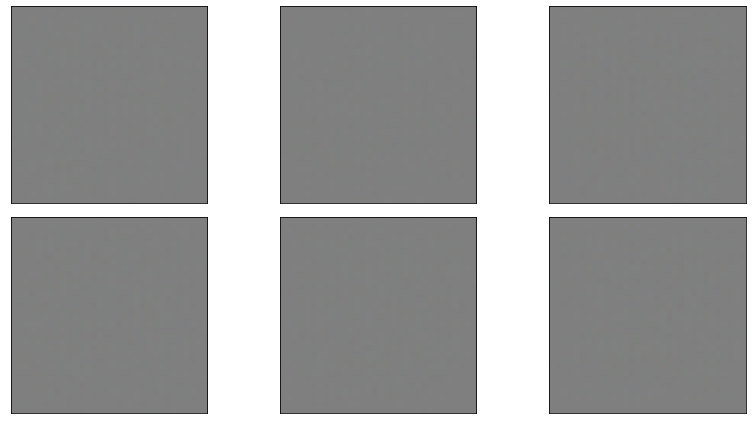

In [8]:
def generate_latent(generator, n_sample=128):
    latent_size = generator.input_shape[1]
    latent = np.random.randn(n_sample, latent_size)
    return latent

def generate_fake_data(generator, n_sample=128):
    latent = generate_latent(generator, n_sample)
    out = generator.predict(latent)
    return out

fake = generate_fake_data(generator, 6).squeeze()  # remove the channels dimension
print(fake.shape, np.min(fake), np.max(fake))
fake = ((fake + 1) * 255 / 2).astype(int)
plot_images(fake, nrow=2, ncol=3)

In [9]:
class GAN:
    def __init__(self, generator, discriminator, data, test_data,
                 name="cifar10", **kwargs):
        self.generator = generator
        self.discriminator = discriminator
        self.data = data
        self.test_data = test_data
        self.name = name
        self.setup(**kwargs)
        
    def setup(self,
              lr_d=0.0002, beta1_d=0.5, beta2_d=0.999,
              lr_g=0.0002, beta1_g=0.5, beta2_g=0.999):
        self.discriminator.trainable = True
        opt = Adam(learning_rate=lr_d, beta_1=beta1_d, beta_2=beta2_d)
        self.discriminator.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
        
        self.discriminator.trainable = False
        x = Input(self.generator.input_shape[1:])
        y = self.generator(x)
        y = self.discriminator(y)
        gan = Model(inputs=x, outputs=y)
        opt = Adam(learning_rate=lr_g, beta_1=beta1_g, beta_2=beta2_g)
        gan.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
        self.gan = gan
    
    def train_step(self, batchsize=512, update_discriminator_separately=True):
        # train discriminator
        halfbatch = int(batchsize/2)
        x_real = self.data.get(halfbatch)
        y_real = np.ones((halfbatch, 1))
        x_fake = generate_fake_data(self.generator, halfbatch)
        y_fake = np.zeros((halfbatch, 1))
        if update_discriminator_separately:
            res_d_real = self.discriminator.train_on_batch(x_real, y_real)        
            res_d_fake = self.discriminator.train_on_batch(x_fake, y_fake)
            res_d = tuple((a+b)/2 for a, b in zip(res_d_real, res_d_fake))
        else:
            res_d = self.discriminator.train_on_batch(
                np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
            )
        
        # train generator
        x_gan = generate_latent(self.generator, batchsize)
        y_gan = np.ones((batchsize, 1))
        res_g = self.gan.train_on_batch(x_gan, y_gan)
        
        return res_d, res_g
    
    def evaluate(self, iteration, batchsize=256):
        x_real = self.test_data.get(batchsize)
        y_real = np.ones((batchsize, 1))
        loss_real, acc_real = self.discriminator.evaluate(x_real, y_real, verbose=False)
        x_fake = generate_fake_data(self.generator, batchsize)
        y_fake = np.zeros((batchsize, 1))
        loss_fake, acc_fake = self.discriminator.evaluate(x_fake, y_fake, verbose=False)
        print("\nIter %d: loss=(%.3f, %.3f), acc=(%.3f, %.3f)" % (
              iteration+1, loss_real, loss_fake, acc_real, acc_fake))
        
    def generate_sample_images(self, nrow=4, ncol=8, figsize=(12, 6)):
        fake = generate_fake_data(self.generator, nrow*ncol)
        fake = ((fake + 1) * 255 / 2).astype(int)
        images = plot_images(fake, figsize=figsize, nrow=nrow, ncol=ncol)
        return images
    
    def save_model(self, index):
        path = "out3/%s-generator_%07d.h5" % (self.name, index)
        self.generator.save(path)
        path = "out3/%s-discriminator_%07d.h5" % (self.name, index)
        self.discriminator.save(path)
        
    def train(self, n_iter=10000, batchsize=256, update_discriminator_separately=True,
              eval_by=1000, batchsize_eval=256, nrow=4, ncol=8, figsize=(12, 6)):
        # image from the initial generator
        fig = self.generate_sample_images(nrow=nrow, ncol=ncol, figsize=figsize)
        imagepath = "out3/%s_%07d.png" % (self.name, 0)
        fig.savefig(imagepath)
        plt.close(fig)
        history = {"loss_d":[], "loss_g":[], "acc_d":[], "acc_g":[]}
        for i in range(n_iter):
            (loss_d, acc_d), (loss_g, acc_g) = self.train_step(
                batchsize, update_discriminator_separately=update_discriminator_separately)
            print("\r#%6d: loss=(%.3f, %.3f), acc=(%.3f, %.3f)" % (i+1, loss_d, loss_g, acc_d, acc_g), end="")
            history["loss_d"].append(loss_d)
            history["loss_g"].append(loss_g)
            history["acc_d"].append(acc_d)
            history["acc_g"].append(acc_g)
            if (i+1) % eval_by == 0:
                self.evaluate(i, batchsize_eval)
                fig = self.generate_sample_images(nrow=nrow, ncol=ncol, figsize=figsize)
                imagepath = "out3/%s_%07d.png" % (self.name, i+1)
                fig.savefig(imagepath)
                plt.close(fig)
                self.save_model(i+1)
        return history

# test
gan = GAN(generator, discriminator, data, data, name="test")
history = gan.train(n_iter=10, batchsize=64, eval_by=2)

#     2: loss=(0.691, 0.693), acc=(0.500, 1.000)
Iter 2: loss=(0.686, 0.694), acc=(1.000, 0.000)
#     4: loss=(0.685, 0.693), acc=(0.500, 1.000)
Iter 4: loss=(0.668, 0.694), acc=(1.000, 0.000)
#     6: loss=(0.665, 0.693), acc=(0.500, 1.000)
Iter 6: loss=(0.591, 0.694), acc=(1.000, 0.000)
#     8: loss=(0.596, 0.689), acc=(0.500, 1.000)
Iter 8: loss=(0.363, 0.708), acc=(1.000, 0.000)
#    10: loss=(0.466, 0.673), acc=(0.500, 1.000)
Iter 10: loss=(0.111, 0.771), acc=(1.000, 0.000)


(32, 32, 32, 3) -0.40491688 0.36910817


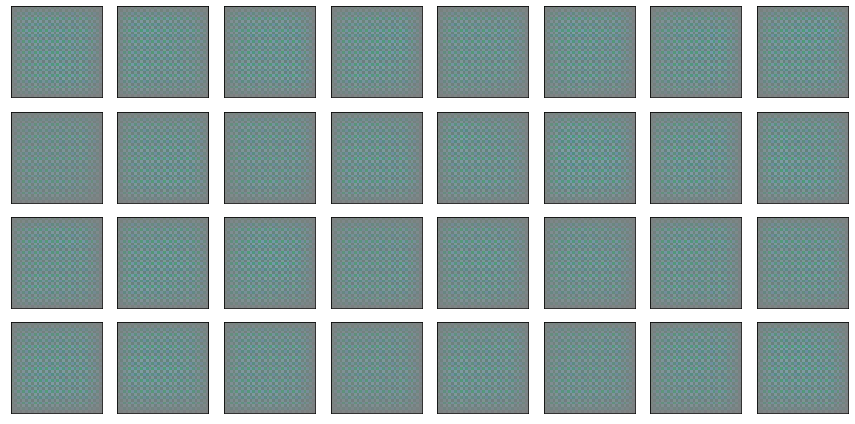

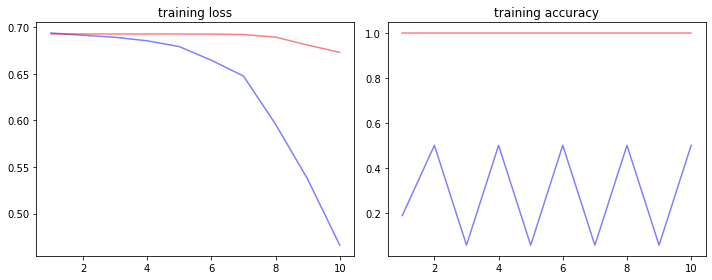

In [10]:
def post_estimation_summary(gan, history):
    fake = generate_fake_data(gan.generator, 32)
    print(fake.shape, np.min(fake), np.max(fake))
    fake = ((fake + 1) * 255 / 2).astype(int)
    fig = plot_images(fake, nrow=4, ncol=8)
    display(fig)
    plt.close(fig)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    n = len(history["loss_d"])
    ax[0].plot(range(1, n+1), history["loss_d"], color="blue", alpha=0.5, label="discriminator")
    ax[0].plot(range(1, n+1), history["loss_g"], color="red", alpha=0.5, label="generator")
    ax[0].set_title("training loss")
    ax[1].plot(range(1, n+1), history["acc_d"], color="blue", alpha=0.5, label="discriminator")
    ax[1].plot(range(1, n+1), history["acc_g"], color="red", alpha=0.5, label="generator")
    ax[1].set_title("training accuracy")
    fig.tight_layout()
    display(fig)
    plt.close(fig)

# test
post_estimation_summary(gan, history)

#  1000: loss=(0.646, 0.753), acc=(0.660, 0.234)
Iter 1000: loss=(0.623, 0.652), acc=(0.777, 0.738)
#  2000: loss=(0.489, 1.056), acc=(0.789, 0.031)
Iter 2000: loss=(0.421, 0.582), acc=(0.727, 0.848)
#  3000: loss=(0.710, 0.847), acc=(0.508, 0.156)
Iter 3000: loss=(0.757, 0.683), acc=(0.348, 0.629)
#  4000: loss=(0.651, 0.727), acc=(0.609, 0.320)
Iter 4000: loss=(0.660, 0.705), acc=(0.488, 0.652)
#  5000: loss=(0.689, 0.846), acc=(0.625, 0.152)
Iter 5000: loss=(0.717, 0.605), acc=(0.461, 0.789)
#  6000: loss=(0.652, 0.776), acc=(0.621, 0.254)
Iter 6000: loss=(0.577, 0.670), acc=(0.617, 0.773)
#  7000: loss=(0.711, 0.770), acc=(0.500, 0.145)
Iter 7000: loss=(0.740, 0.609), acc=(0.219, 0.965)
#  8000: loss=(0.631, 0.820), acc=(0.688, 0.121)
Iter 8000: loss=(0.681, 0.586), acc=(0.367, 0.984)
#  9000: loss=(0.692, 0.717), acc=(0.516, 0.309)
Iter 9000: loss=(0.709, 0.668), acc=(0.230, 0.781)
# 10000: loss=(0.686, 0.734), acc=(0.539, 0.258)
Iter 10000: loss=(0.702, 0.659), acc=(0.234, 0.836)

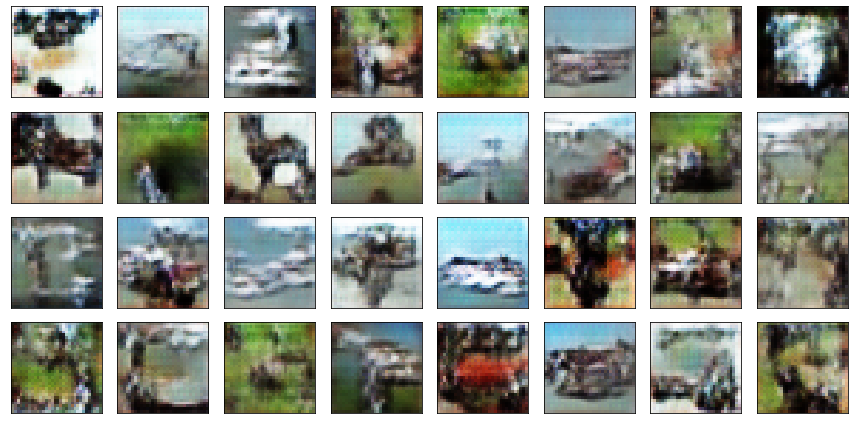

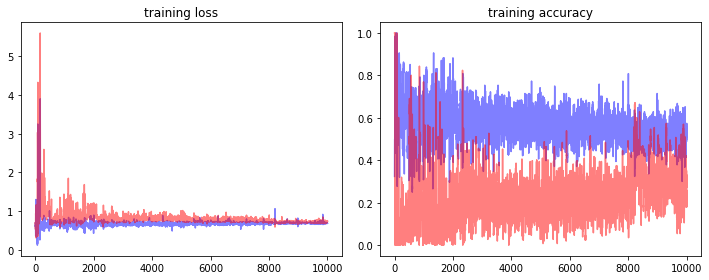

In [11]:
data = Dataset(x_tr, normalizer=Normalizer())
test_data = Dataset(x_te, normalizer=Normalizer())
discriminator = make_discriminator()
generator = make_generator()
gan = GAN(generator, discriminator, data, test_data, name="cifar10")
history = gan.train(n_iter=10000)

post_estimation_summary(gan, history)

#  1000: loss=(0.688, 0.735), acc=(0.523, 0.184)
Iter 1000: loss=(0.710, 0.661), acc=(0.219, 0.898)
#  2000: loss=(0.690, 0.728), acc=(0.566, 0.203)
Iter 2000: loss=(0.700, 0.676), acc=(0.336, 0.809)
#  3000: loss=(0.696, 0.692), acc=(0.461, 0.566)
Iter 3000: loss=(0.689, 0.693), acc=(0.629, 0.410)
#  4000: loss=(0.685, 0.723), acc=(0.566, 0.254)
Iter 4000: loss=(0.702, 0.674), acc=(0.262, 0.859)
#  5000: loss=(0.689, 0.709), acc=(0.496, 0.355)
Iter 5000: loss=(0.697, 0.684), acc=(0.355, 0.672)
#  6000: loss=(0.693, 0.711), acc=(0.508, 0.246)
Iter 6000: loss=(0.703, 0.674), acc=(0.250, 0.891)
#  7000: loss=(0.684, 0.704), acc=(0.602, 0.320)
Iter 7000: loss=(0.693, 0.687), acc=(0.473, 0.676)
#  8000: loss=(0.694, 0.707), acc=(0.449, 0.281)
Iter 8000: loss=(0.701, 0.678), acc=(0.219, 0.867)
#  9000: loss=(0.695, 0.709), acc=(0.516, 0.262)
Iter 9000: loss=(0.694, 0.682), acc=(0.340, 0.832)
# 10000: loss=(0.691, 0.703), acc=(0.484, 0.336)
Iter 10000: loss=(0.687, 0.683), acc=(0.355, 0.762)

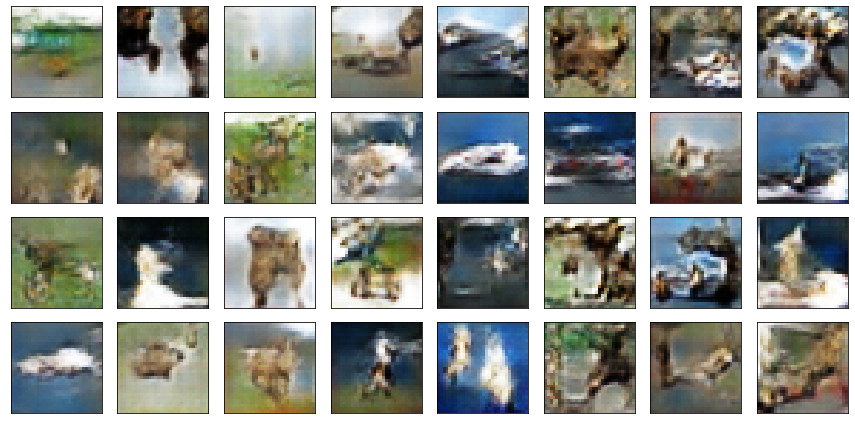

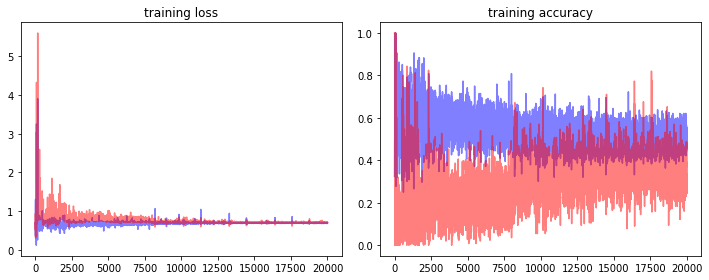

In [12]:
tmp = gan.train(n_iter=10000)
history = {name: history[name] + tmp[name] for name in history}
post_estimation_summary(gan, history)

#  1000: loss=(0.690, 0.708), acc=(0.562, 0.320)
Iter 1000: loss=(0.695, 0.680), acc=(0.316, 0.797)
#  2000: loss=(0.700, 0.702), acc=(0.457, 0.402)
Iter 2000: loss=(0.693, 0.690), acc=(0.543, 0.504)
#  3000: loss=(0.694, 0.703), acc=(0.484, 0.395)
Iter 3000: loss=(0.697, 0.684), acc=(0.406, 0.680)
#  4000: loss=(0.691, 0.700), acc=(0.492, 0.391)
Iter 4000: loss=(0.696, 0.684), acc=(0.312, 0.727)
#  5000: loss=(0.697, 0.708), acc=(0.461, 0.289)
Iter 5000: loss=(0.701, 0.679), acc=(0.203, 0.832)
#  6000: loss=(0.691, 0.703), acc=(0.527, 0.387)
Iter 6000: loss=(0.700, 0.682), acc=(0.363, 0.746)
#  7000: loss=(0.689, 0.701), acc=(0.516, 0.398)
Iter 7000: loss=(0.697, 0.689), acc=(0.398, 0.625)
#  8000: loss=(0.704, 0.686), acc=(0.395, 0.508)
Iter 8000: loss=(0.697, 0.700), acc=(0.309, 0.617)
#  9000: loss=(0.690, 0.701), acc=(0.543, 0.332)
Iter 9000: loss=(0.692, 0.685), acc=(0.383, 0.762)
# 10000: loss=(0.690, 0.713), acc=(0.512, 0.312)
Iter 10000: loss=(0.702, 0.678), acc=(0.227, 0.855)

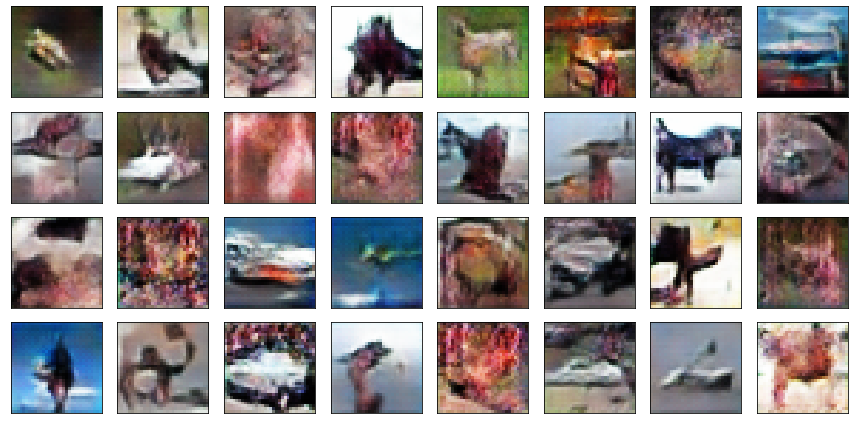

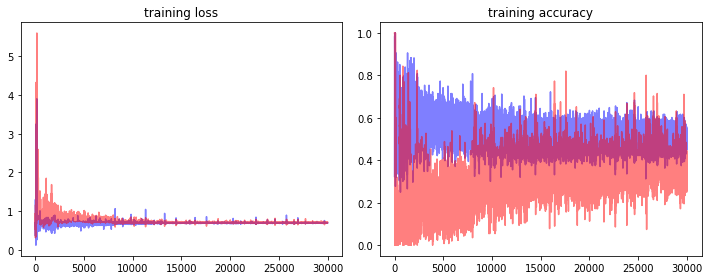

In [13]:
tmp = gan.train(n_iter=10000)
history = {name: history[name] + tmp[name] for name in history}
post_estimation_summary(gan, history)

#  1000: loss=(0.695, 0.695), acc=(0.480, 0.449)
Iter 1000: loss=(0.699, 0.685), acc=(0.254, 0.711)
#  2000: loss=(0.687, 0.700), acc=(0.559, 0.375)
Iter 2000: loss=(0.698, 0.681), acc=(0.312, 0.883)
#  3000: loss=(0.691, 0.701), acc=(0.508, 0.387)
Iter 3000: loss=(0.696, 0.687), acc=(0.402, 0.680)
#  4000: loss=(0.692, 0.703), acc=(0.457, 0.398)
Iter 4000: loss=(0.694, 0.690), acc=(0.508, 0.594)
#  5000: loss=(0.697, 0.704), acc=(0.449, 0.379)
Iter 5000: loss=(0.691, 0.690), acc=(0.484, 0.512)
#  6000: loss=(0.695, 0.695), acc=(0.531, 0.465)
Iter 6000: loss=(0.688, 0.696), acc=(0.547, 0.500)
#  7000: loss=(0.687, 0.707), acc=(0.547, 0.305)
Iter 7000: loss=(0.696, 0.679), acc=(0.340, 0.836)
#  8000: loss=(0.693, 0.700), acc=(0.559, 0.348)
Iter 8000: loss=(0.697, 0.686), acc=(0.273, 0.816)
#  9000: loss=(0.693, 0.705), acc=(0.492, 0.367)
Iter 9000: loss=(0.697, 0.682), acc=(0.289, 0.812)
# 10000: loss=(0.691, 0.712), acc=(0.504, 0.277)
Iter 10000: loss=(0.694, 0.679), acc=(0.285, 0.895)

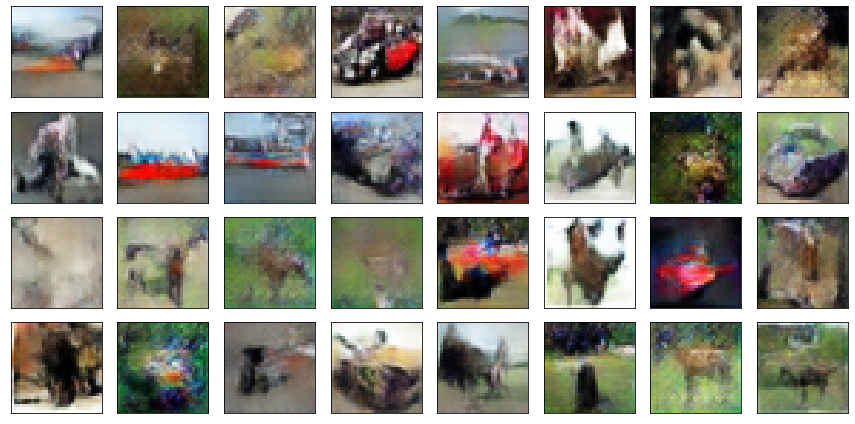

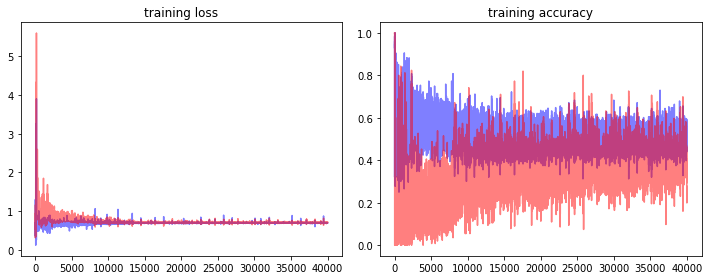

In [14]:
tmp = gan.train(n_iter=10000)
history = {name: history[name] + tmp[name] for name in history}
post_estimation_summary(gan, history)

#  1000: loss=(0.686, 0.694), acc=(0.582, 0.426)
Iter 1000: loss=(0.694, 0.696), acc=(0.359, 0.629)
#  2000: loss=(0.691, 0.702), acc=(0.512, 0.371)
Iter 2000: loss=(0.698, 0.685), acc=(0.312, 0.750)
#  3000: loss=(0.686, 0.693), acc=(0.500, 0.449)
Iter 3000: loss=(0.693, 0.688), acc=(0.340, 0.711)
#  4000: loss=(0.695, 0.699), acc=(0.484, 0.453)
Iter 4000: loss=(0.695, 0.690), acc=(0.445, 0.586)
#  5000: loss=(0.691, 0.699), acc=(0.562, 0.387)
Iter 5000: loss=(0.697, 0.682), acc=(0.363, 0.754)
#  6000: loss=(0.694, 0.702), acc=(0.473, 0.449)
Iter 6000: loss=(0.690, 0.690), acc=(0.484, 0.660)
#  7000: loss=(0.689, 0.705), acc=(0.547, 0.422)
Iter 7000: loss=(0.692, 0.695), acc=(0.488, 0.520)
#  8000: loss=(0.689, 0.697), acc=(0.539, 0.422)
Iter 8000: loss=(0.698, 0.681), acc=(0.273, 0.879)
#  9000: loss=(0.697, 0.705), acc=(0.492, 0.414)
Iter 9000: loss=(0.700, 0.680), acc=(0.273, 0.824)
# 10000: loss=(0.692, 0.704), acc=(0.523, 0.402)
Iter 10000: loss=(0.696, 0.686), acc=(0.324, 0.711)

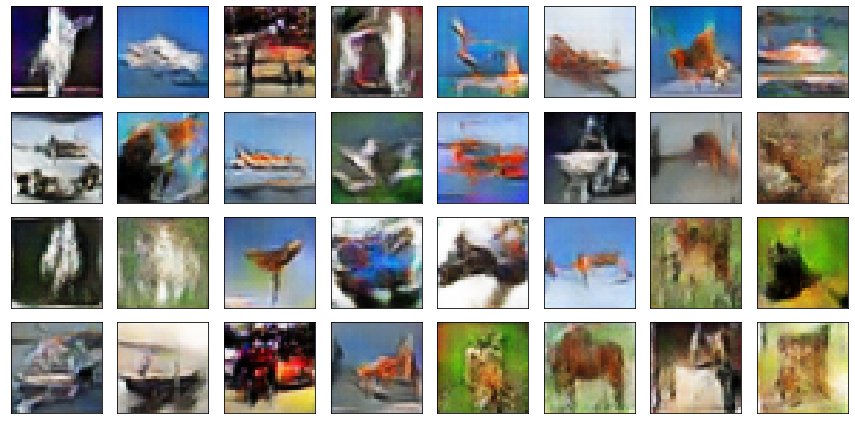

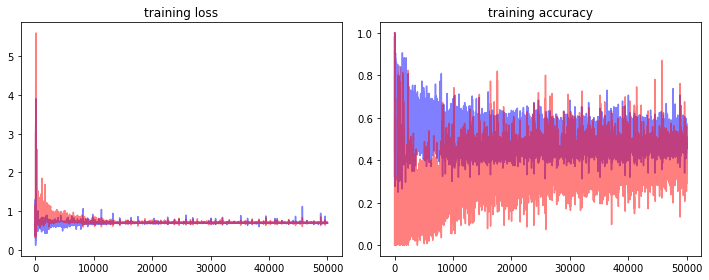

In [15]:
tmp = gan.train(n_iter=10000)
history = {name: history[name] + tmp[name] for name in history}
post_estimation_summary(gan, history)

#  1000: loss=(0.690, 0.704), acc=(0.516, 0.336)
Iter 1000: loss=(0.698, 0.679), acc=(0.273, 0.859)
#  2000: loss=(0.690, 0.701), acc=(0.516, 0.438)
Iter 2000: loss=(0.700, 0.686), acc=(0.344, 0.625)
#  3000: loss=(0.689, 0.713), acc=(0.559, 0.277)
Iter 3000: loss=(0.705, 0.677), acc=(0.230, 0.844)
#  4000: loss=(0.699, 0.696), acc=(0.477, 0.438)
Iter 4000: loss=(0.695, 0.688), acc=(0.328, 0.699)
#  5000: loss=(0.692, 0.703), acc=(0.543, 0.398)
Iter 5000: loss=(0.697, 0.678), acc=(0.312, 0.836)
#  6000: loss=(0.692, 0.696), acc=(0.523, 0.473)
Iter 6000: loss=(0.696, 0.684), acc=(0.363, 0.727)
#  7000: loss=(0.698, 0.692), acc=(0.449, 0.480)
Iter 7000: loss=(0.693, 0.690), acc=(0.449, 0.629)
#  8000: loss=(0.685, 0.701), acc=(0.570, 0.414)
Iter 8000: loss=(0.695, 0.686), acc=(0.352, 0.719)
#  9000: loss=(0.699, 0.692), acc=(0.426, 0.539)
Iter 9000: loss=(0.694, 0.694), acc=(0.473, 0.469)
# 10000: loss=(0.695, 0.708), acc=(0.488, 0.355)
Iter 10000: loss=(0.700, 0.680), acc=(0.309, 0.797)

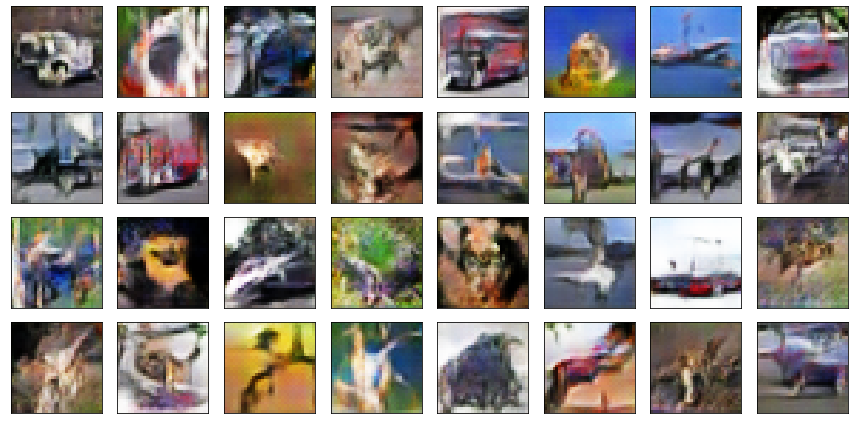

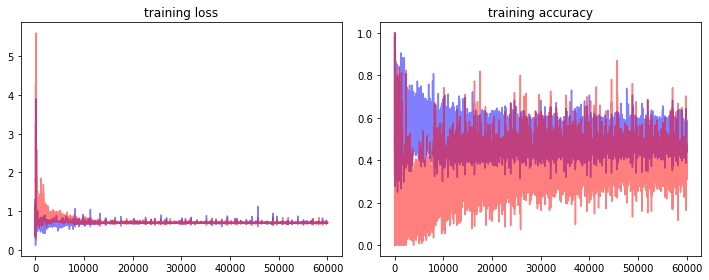

In [16]:
tmp = gan.train(n_iter=10000)
history = {name: history[name] + tmp[name] for name in history}
post_estimation_summary(gan, history)